<a href="https://colab.research.google.com/github/9ruddls3/Facial_Expression_Recognition/blob/master/Emotion_Recognition_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 Face Emotion Recognition and Detection은 다음의 논문을 기반으로 하여 진행하였습니다.   

H. Zhang, A. Jolfaei and M. Alazab   
"A Face Emotion Recognition Method Using  Convolutional Neural Network and Image Edge Computing,"   
in IEEE Access, vol. 7, pp. 159081-159089, 2019, doi: 10.1109/ACCESS.2019.2949741.

In [ ]:
from os import listdir
import xml.etree.ElementTree as ET
from tqdm import tqdm

#annotation 담은 xml 파일들이 위치한 좌표
path = '/content/drive/My Drive/Datasets/Face/train/annotations'

# 파일이름, 박스 좌표를 담은 2중 리스트, 해당 영역안의 감정을 담은 리스트, 이미지 넓이, 이미지 높이 를 key로 담은 Dictionary 
label_dict = {}

# label_dict의 Value List 초기 선언
label_dict['file_name'] = []
label_dict['b_boxes'] = []
label_dict['emotions'] = []
label_dict['img_w'] = []
label_dict['img_h'] = []

# 박스의 좌표를 담을 b_box(list)와, 이미지당 bounding box들을 담을 b_boxes(list), 그리고 emotion을 담을 list
b_box = []
b_boxes = []
emotion = []

# 해당 데이터셋의 모든 bounding Box 수
num_bboxes = 0

# annotation xml들을 파싱하여, 모든 이미지에 대한 bounding boxes 좌표정보, emotion, 이미지의 넓이 및 높이를 loop문을 통해 label_dict에 선언
for xml in tqdm(list(listdir(path))):
    tree = ET.parse(path+'/'+xml)
    root = tree.getroot()
    for x in root:
        if x.tag=='filename': #파일 이름과,  
            label_dict['file_name'].append(x.text)
        elif x.tag=='size':
            for y in x:
                if y.tag=='width':
                    label_dict['img_w'].append(y.text) 
                elif y.tag=='height':
                    label_dict['img_h'].append(y.text) 
        elif x.tag == 'object':
            for y in x:
                if y.tag =='name': 
                    emotion.append(y.text)
                elif y.tag =='bndbox':
                    for z in y:
                        b_box.append(int(z.text))
                    b_boxes.append(b_box)
                    num_bboxes +=1
                    b_box = []
    label_dict['emotions'].append(emotion)
    label_dict['b_boxes'].append(b_boxes)
    b_boxes = []
    emotion = []

100%|██████████| 1688/1688 [16:44<00:00,  1.68it/s]


In [ ]:
import pandas as pd
df_label = pd.DataFrame(label_dict)
#총 표졍 영역 갯수와, 데이터셋의 전반적인 정보를 담은 데이터프레임 생성 및 조회
print(num_bboxes)
df_label

2116


,file_name,b_boxes,emotions,img_w,img_h
0,casual-asian-upset-man-sitting-260nw-486963874...,"[[74, 87, 103, 115]]",[anger],173,280
1,2.https%3A%2F%2Fblogs-images.forbes.com%2Fgold...,"[[338, 87, 526, 344]]",[anger],960,444
2,276.KIMREEAA-KR.jpg,"[[446, 257, 650, 498]]",[smile],905,1280
3,90.crop2.JPG,"[[88, 24, 183, 153]]",[anger],327,380
4,321.image.jpg,"[[353, 202, 509, 375], [103, 434, 326, 718], [...","[smile, neutral, smile]",1280,718
...,...,...,...,...,...
1683,150.crop.JPG,"[[331, 257, 372, 316], [312, 149, 339, 184]]","[neutral, neutral]",551,539
1684,295.500_F_252845109_BZkKOmGZc7YMryAIc1lyDkLn67...,"[[55, 44, 154, 186]]",[smile],500,334
1685,431.flowers-children-brunette-Asian-smiling-bl...,"[[965, 123, 1174, 385]]",[smile],1920,1080
1686,616.14683659-excited-and-happy-asian-family-ju...,"[[346, 394, 400, 454], [791, 173, 857, 246], [...","[smile, smile, smile, smile]",1300,866


In [ ]:
import numpy as np
from PIL import Image 

np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})

# 각 표정이 담긴 영역을 CROP 한 뒤, GRAYSCALE로 변환한 pixel array(w,h)을 담은 리스트 생성

box_arr_list = []

img_path = '/content/drive/My Drive/Datasets/Face/train/img'

for i,x in tqdm(enumerate(zip(df_label['file_name'], df_label['b_boxes']))):
    for box in x[1]:
        im = Image.open(img_path+'/'+x[0]).crop(tuple(box)).convert('L')
        box_arr_list.append(np.asarray(im))

1688it [17:44,  1.59it/s]


In [ ]:
import cv2

# 픽셀들을 논문의 기록된 수식을 기반으로 Scale_Normalization 한 후, 해상도(96,96)로 바꿔 저장

norm_lis=[]

for it in tqdm(box_arr_list):
    res = cv2.resize(it, dsize=(96, 96), interpolation=cv2.INTER_LINEAR_EXACT)
    equ = cv2.equalizeHist(res)
    norm_lis.append(equ)

100%|██████████| 2116/2116 [00:00<00:00, 13752.22it/s]


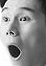

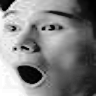

In [ ]:
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# 원본 - Resize & Linear Interpolation 후 이미지 확인 및 비교

img= box_arr_list[62]
cv2_imshow(img)

img = norm_lis[62]
cv2_imshow(img)

In [ ]:
len(norm_lis)

2116

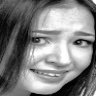

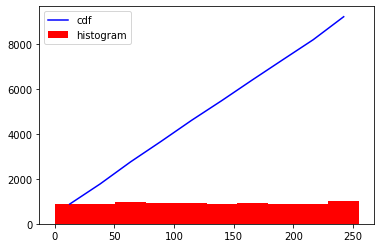

In [ ]:
# Gray-Level-Equilization 후 Gray-Score 분포 및 Cumulative Distribution 확인

img = norm_lis[1800]

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

img = norm_lis[1800]

hist,bins = np.histogram(np.concatenate(img).ravel())

cdf = hist.cumsum()
cdf_x = [(x+y)/2 for x,y in zip(bins,bins[1:])]

plt.plot(cdf_x, cdf, color = 'b')
plt.hist(img.flatten(),color='r')
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

In [ ]:
# 각 이미지 영역마다의 Emotion(label) 리스트

label = df_label['emotions']
emotions = [] 
for lis in label:
    for emo in lis:
        emotions.append(emo)

In [ ]:
from collections import Counter
Counter(emotions)

Counter({'anger': 379,
         'neutral': 573,
         'sad': 311,
         'smile': 627,
         'surprise': 226})

In [ ]:
import torch
from torchvision import transforms

# Gray-Level-Equilization 처리 후, label(emotion)과 함께 Pytorch 에 학습시키도록 Dataloader로 변환
# Pixel좌표는 GPU 변수 처리 

input_dataset  = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype =  torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
to_tensor = transforms.ToTensor()

for image, emotion in tqdm(zip(norm_lis, emotions)):
    tsr = to_tensor(image).to(device)
    input_dataset.append((tsr, emotion))

DataLoader = torch.utils.data.DataLoader(input_dataset, shuffle=True)

2116it [00:08, 245.69it/s]


(tensor([[[0.0471, 0.0549, 0.0667,  ..., 0.0314, 0.0275, 0.0235],
         [0.0510, 0.0510, 0.0510,  ..., 0.0392, 0.0353, 0.0314],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.7765, 0.7765, 0.7647,  ..., 0.4118, 0.2667, 0.2039],
         [0.8667, 0.8235, 0.7373,  ..., 0.3294, 0.1490, 0.0980],
         [0.7647, 0.7647, 0.7490,  ..., 0.2196, 0.0745, 0.0353]]],
       device='cuda:0'), 'surprise')


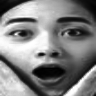

In [ ]:
# Tensor변환 확인

import torchvision

print(DataLoader.dataset[333])
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(DataLoader.dataset[333][0].to('cpu'))
img

In [ ]:
#Convultional-Neural-Network Net 

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable

class CNN_net(nn.Module):
    def __init__(self):
        super(CNN_net, self).__init__()
        self.relu = nn.ReLU(True)
        self.conv_1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0)
        self.conv_3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0)
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.flatten = nn.Flatten()
        self.f_connection = nn.Linear(51200,5)
        self.soft_max = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.max_pool(x)
        x = self.relu(self.conv_3(x))
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.f_connection(x)
        return x

# Forward Propagation 에서 Softmax를 없앤 이유 : pytorch에서의 CrossEntropyLoss() 함수에, SoftMax가 포함되기 때문

In [ ]:
# 모델 parameter 초기화 함수

def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal(m.weight, gain=1)
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()

In [ ]:
# 학습 및 저장

import time
import torch.optim.lr_scheduler as lrs

net = CNN_net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = lrs.StepLR(optimizer, step_size=20, gamma=0.8)

net.apply(reset)
net.train()

classes = {'anger':0, 'sad':1, 'neutral':2, 'smile':3, 'surprise':4 }
num_train = len(df_label)
epochs = 1000

for epoch in range(epochs):
    scheduler.step() 
    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
              'start epoch %d/%d:' % (epoch + 1, epochs), 'learning_rate =', scheduler.get_lr()[0])
    
    iter_each_epoch = num_train
    tot_loss = 0
    
    for i, data in enumerate(DataLoader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        y = torch.LongTensor([classes[labels[0]]]).to(device)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        tot_loss += loss.data

        if i == 0 or (i + 1) % 300 == 0 :
            print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),'iter %d loss = %f' % (i + 1, loss.data))

    tot_loss /= iter_each_epoch
    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
          'epoch %d/%d average_loss = %f\n' % (epoch + 1, epochs , tot_loss))

torch.save(net.state_dict(), '/content/drive/My Drive/Emotion_Recognition_model.pth')

#Model_Size =< 2MB, 하지만 학습 이미지 데이터의 해상도를 96*96로 일방적으로 통일시켰기에, 탁월한 성능은 어려울 것으로 판단 (300회 반복 학습 기준)

2020-07-06 05:30:46 start epoch 1/1000: learning_rate = 0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2020-07-06 07:24:14 iter 1500 loss = 1.312060
2020-07-06 07:24:16 iter 1800 loss = 2.237115
2020-07-06 07:24:18 iter 2100 loss = 1.308633
2020-07-06 07:24:18 epoch 546/1000 average_loss = 1.934414

2020-07-06 07:24:18 start epoch 547/1000: learning_rate = 0.0002417851639229262
2020-07-06 07:24:18 iter 1 loss = 1.216174
2020-07-06 07:24:20 iter 300 loss = 1.718419
2020-07-06 07:24:22 iter 600 loss = 1.921959
2020-07-06 07:24:23 iter 900 loss = 1.925611
2020-07-06 07:24:25 iter 1200 loss = 1.221710
2020-07-06 07:24:27 iter 1500 loss = 1.291207
2020-07-06 07:24:29 iter 1800 loss = 1.301147
2020-07-06 07:24:30 iter 2100 loss = 1.214237
2020-07-06 07:24:30 epoch 547/1000 average_loss = 1.934411

2020-07-06 07:24:30 start epoch 548/1000: learning_rate = 0.0002417851639229262
2020-07-06 07:24:30 iter 1 loss = 1.718714
2020-07-06 07:24:32 iter 300 loss = 2.231137
2020-07-06 07:24:34 iter 600 loss = 1.723902
2020-07-06 07:24:36 iter 900 loss = 1.724985
2020-0

In [ ]:
def data_prepare(img_path,area):
    img = Image.open(img_path).crop((area[0],area[1],area[0]+area[2],area[1]+area[3])).convert('L')
    img = np.asarray(img)
    nump = np.zeros((img.shape[0]-2,img.shape[1]-2))
    norm = []
    for y,axis in enumerate(img):
        if y ==0 or y== len(img)-1:
            pass
        else:
            for ind,x in enumerate(axis): 
                if ind==0 or ind==len(axis)-1:
                    pass
                else:
                    norm.append(4*img[y+1][ind+1]-2*img[y+1][ind-1]-img[y-1][ind+1])
            nump[y-1] = norm
            norm = []
    img = cv2.resize(nump, dsize=(96, 96), interpolation=cv2.INTER_LINEAR_EXACT)
    src = img.flatten().astype('uint8')
    hist, bins = np.histogram(src, 256, [0, 256])  #, 256, [0, 256]
    cdf = hist.cumsum()
    cdf_mask = np.ma.masked_equal(cdf,0)
    cdf_mask = (cdf_mask - cdf_mask.min())*255/(cdf_mask.max()-cdf_mask.min())
    cdf = np.ma.filled(cdf_mask,0).astype('uint8')
    equ = cdf[img.astype('uint8')]
    return torch.from_numpy(equ[None,None,...]).type(torch.cuda.FloatTensor)

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=621e5e4e3b6cda94609ac0232fd92cb27260e9478e540aff31685726ec696566
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
import face_recognition

In [ ]:
trump_image = face_recognition.load_image_file('/content/drive/My Drive/Datasets/Face/train/img/321.image.jpg')
face_locations = face_recognition.face_locations(trump_image)
face_locations 

[(439, 349, 706, 82), (219, 304, 374, 150), (201, 531, 387, 345)]

In [ ]:
import cv2

(439, 349, 706, 82)
(219, 304, 374, 150)
(201, 531, 387, 345)


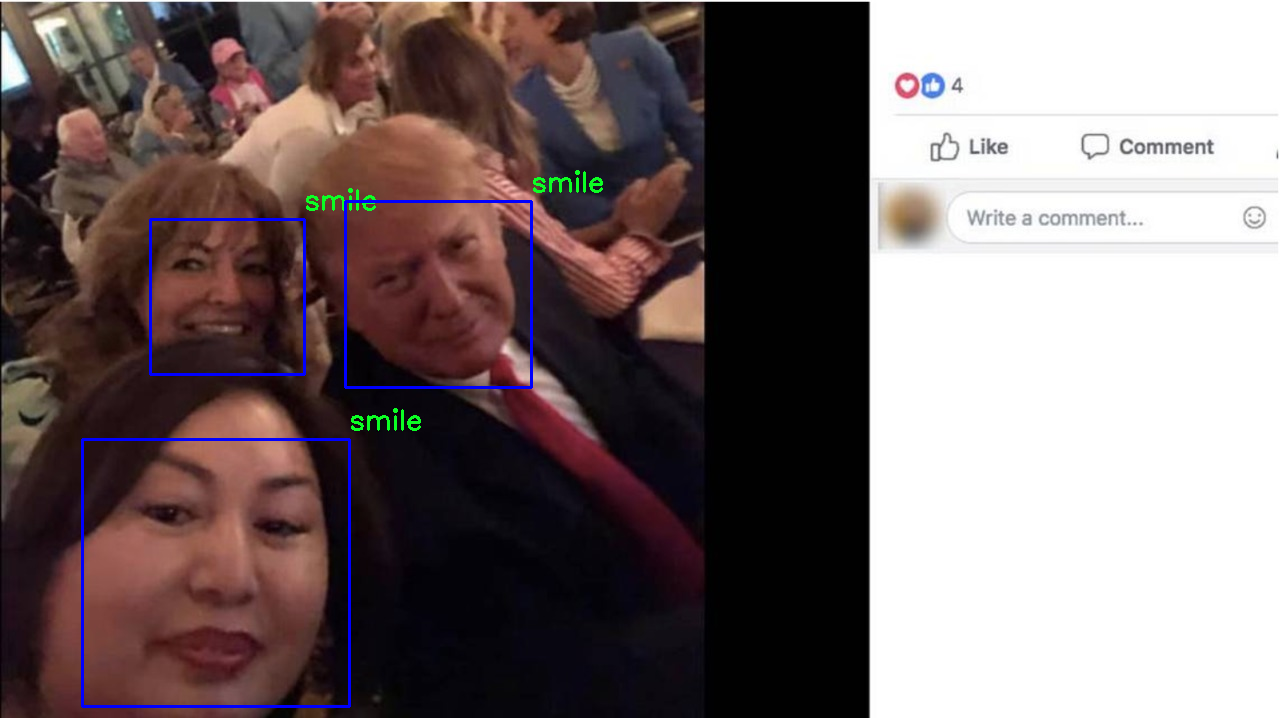

In [ ]:
# 참고 논문에서는, RCNN or Faster-RCNN 과 같이 객체인식, 분류를 동시에 학습시키지 않고, 
# 더 많은 이미지 전처리 과정을 통해 속성간의 변별력을 높히고 분류 모델을 학습시켜 분류 정확성을 높힘
# 대신 Haar Classifier를 통해 안면을 인식하는것으로, 객체 인식에 대한 Task를 줄인것으로 확인됨

# 하지만 Haar Classifier 로 인한 안면 인식 성능은, 정면의 경우에서만 뛰어난것으로 보임
# 얼굴이 측면을 보고있거나 정면이라도, 각도가 이울어져 있는 경우, 다양한 표정에서의 안면 인식률이 낮음
# 이를 개선하기 위한 다른 안면 인식 방법론을 모색하고, 해당 방법론을 적용시키면 다양한 표정에서의 높은 감정인식이
# 가능할 것으로 추정됨 

ind_classes = { 0:'anger', 1:'sad', 2:'neutral', 3:'smile', 4:'surprise' }


test_img = cv2.imread('/content/drive/My Drive/Datasets/Face/train/img/321.image.jpg')

face_locations = face_recognition.face_locations(trump_image)

for (x,y,w,h) in face_locations:
    print((x,y,w,h))
    test_tensor = data_prepare('/content/drive/My Drive/Datasets/Face/train/img/321.image.jpg', (y,x,h,w))
    result = net(test_tensor).tolist()[0]
    emo = ind_classes[result.index(max(result))]
    cv2.rectangle(test_img,(y,x),(h,w),(255,0,0),2)
    cv2.putText(test_img, emo, (y, x-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

from google.colab.patches import cv2_imshow

cv2_imshow(test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
